# Analyse ROMY Events

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_cwt_all import plot_cwt_all
from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results

## Configurations

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2023-09-08 22:13:00",  # Start time
    'tend': "2023-09-08 23:00:00",  # End time

    # event
    'origin_time': "2023-09-08 22:11:00",
    'magnitude': 6.8,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["GR.FUR..BHZ", "GR.FUR..BHN", "GR.FUR..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "sds",  # "fdsn" | "sds" | "mseed_file"

    # Path to SDS for rotation and translation data
    'path_to_sds_rot': "/home/andbro/freenas/romy_archive/",    # SDS path for rotation data
    'path_to_sds_tra': "/home/andbro/bay200/mseed_online/archive/",  # SDS path for translation data

    # Path to inventory of rotation and translation sensor
    'path_to_inv_rot': "/home/andbro/kilauea-data/stationxml_ringlaser/station_BW_ROMY.xml",  # Rotation station inventory
    'path_to_inv_tra': "/home/andbro/kilauea-data/stationxml_ringlaser/station_GR_FUR.xml",  # Translation station inventory
    
    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Set rotation of components
    'rotate_zne': True,

    # Rotate ROMY components
    'use_romy_zne': True,

    # Remove responses
    'tra_remove_response': True,
    'rot_remove_sensitivity': True,

    # Project information
    'project': "ROMY_Analysis",  # Project name

    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'time_win_sec': 30,          # Window length in seconds
    'time_win_overlap': 15,  # Window overlap in seconds

    # Optional parameters
    'verbose': True,            # Print detailed information
}

Store configurations as Yaml File

In [3]:
filename = f"{config['tbeg'][:10].replace('-','')}_M{str(config['magnitude']).replace('.','')}"

sixdegrees.store_as_yaml(config, "./config/"+filename)

 -> file ./config/20230908_M68.yml already exists. Aborting...


Setup a sixdegrees object

In [4]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [5]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

Get key information about the event

In [6]:
try:
    ev = sd.get_event_info(origin_time=config['origin_time'],
                       base_catalog="USGS",
                       magnitude=config['magnitude'])
except:
    print("No event found")
    ev = {
        "backazimuth": 0,
        "distance_km": 0,
        "origin_time": config['origin_time'],
        "magnitude": config['magnitude']
    }

Found event:
Origin time: 2023-09-08T22:11:01.405000Z
Magnitude: 6.8 mww
Location: 31.058°N, -8.385°E
Depth: 19.0 km
Epicentral Distance: 2526.01 km
Epicentral Distance: 22.7°
Backazimuth: 228.40°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [7]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching GR.FUR..BHZ data from SDS
-> fetching GR.FUR..BHN data from SDS
-> fetching GR.FUR..BHE data from SDS
-> translation inventory provided: /home/andbro/kilauea-data/stationxml_ringlaser/station_GR_FUR.xml
-> removing response: ACC
-> rotating translational data ZNE to ZNE
3 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
GR.FUR..BHN | 2023-09-08T22:12:58.990000Z - 2023-09-08T23:00:00.990000Z | 20.0 Hz, 56441 samples
GR.FUR..BHE | 2023-09-08T22:12:58.989999Z - 2023-09-08T23:00:00.989999Z | 20.0 Hz, 56441 samples
-> fetching BW.ROMY.10.BJZ data from SDS
-> fetching BW.ROMY..BJU data from SDS
-> fetching BW.ROMY..BJV data from SDS
-> rotation inventory provided: /home/andbro/kilauea-data/stationxml_ringlaser/station_BW_ROMY.xml
-> rotated ROMY data using rotate_romy_zne (keep_z=True)
3 Trace(s) in Stream:
BW.ROMY..BJZ | 2023-09-08T22:12:59.011600Z - 2023-09-08T23:00:01.011600Z | 20.0 Hz, 56441 samples
BW.ROMY..

Ensure that all traces of stream have the same sample size

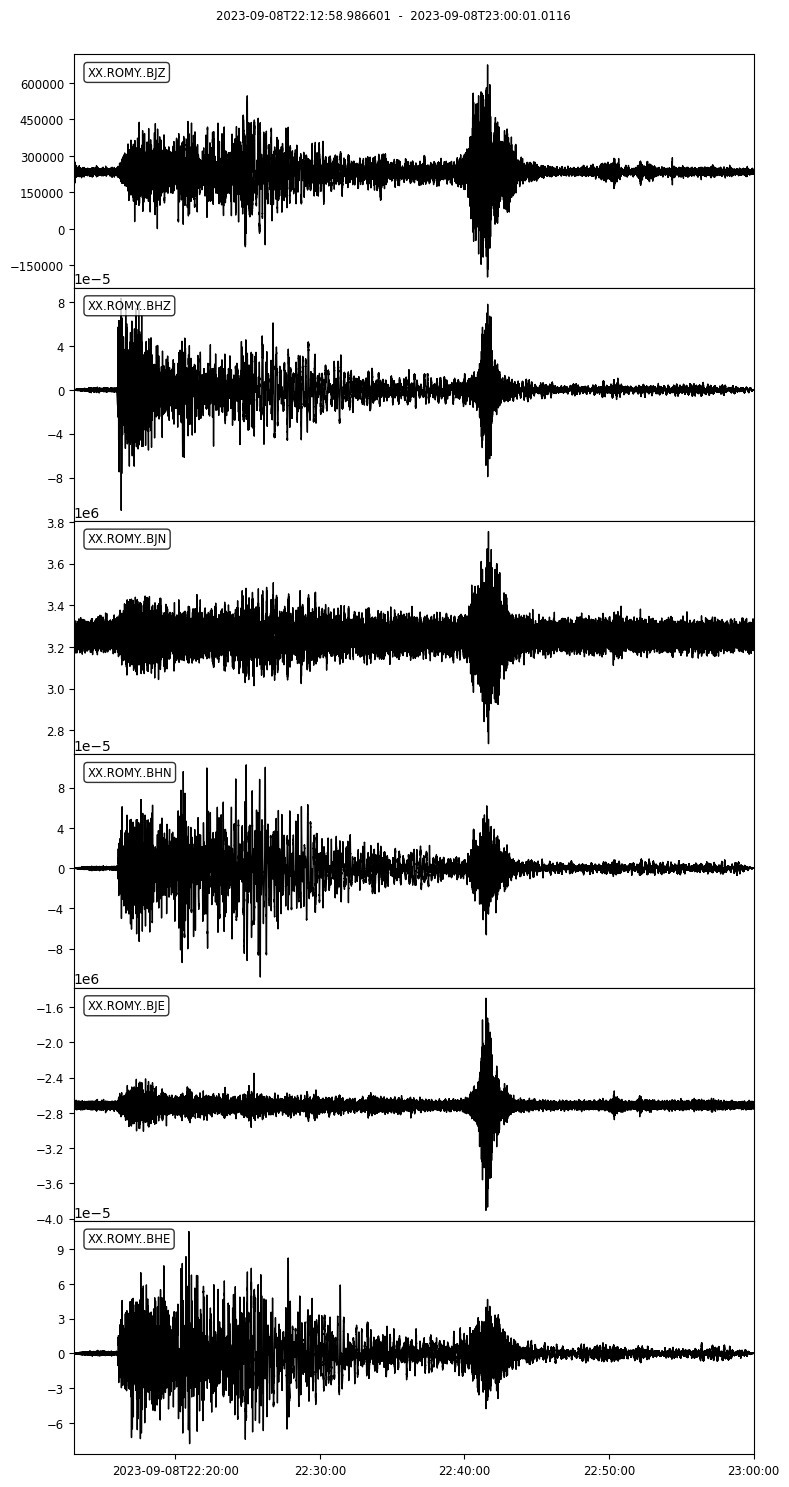

In [8]:
sd.st.plot(equal_scale=False);

In [9]:
sd.trim_stream(set_common=True, set_interpolate=False)

### Only required for time lag correction

In [10]:
# #finde (and correct) time lag between translation and rotation data
# sd.get_component_lag(normalize=True,
#                      baz=ev['backazimuth'],
#                      correct=True)

# # update endtime
# sd.tend = sd.tbeg+25

# # trim stream
# sd.st = sd.st.trim(sd.tbeg, sd.tend)

# sd.st.plot(equal_scale=False);

### Write data to file or SDS system

In [11]:
# write to mseed file
# sd.st.write(f"./data/romy_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

### Wavelet Comparsion

In [ ]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:

    try:
        # Rotation components
        rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Rotation"] = sd.compute_cwt(
            rot_data.times(), rot_data.data, rot_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for rotation")
    try:
        # Translation components
        acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Translation"] = sd.compute_cwt(
            acc_data.times(), acc_data.data, acc_data.stats.delta,
            normalize=True
        )
    except:
        print(f"No {comp} data for ranslation")


No Z data for rotation


In [ ]:
# Then plot all components
fig = plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=1
)

IndexError: list index out of range

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [12]:
sd.filter_data(fmin=0.01, fmax=0.1, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [13]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


let's compare the waveforms of the rotation (red) and translational (black) components 

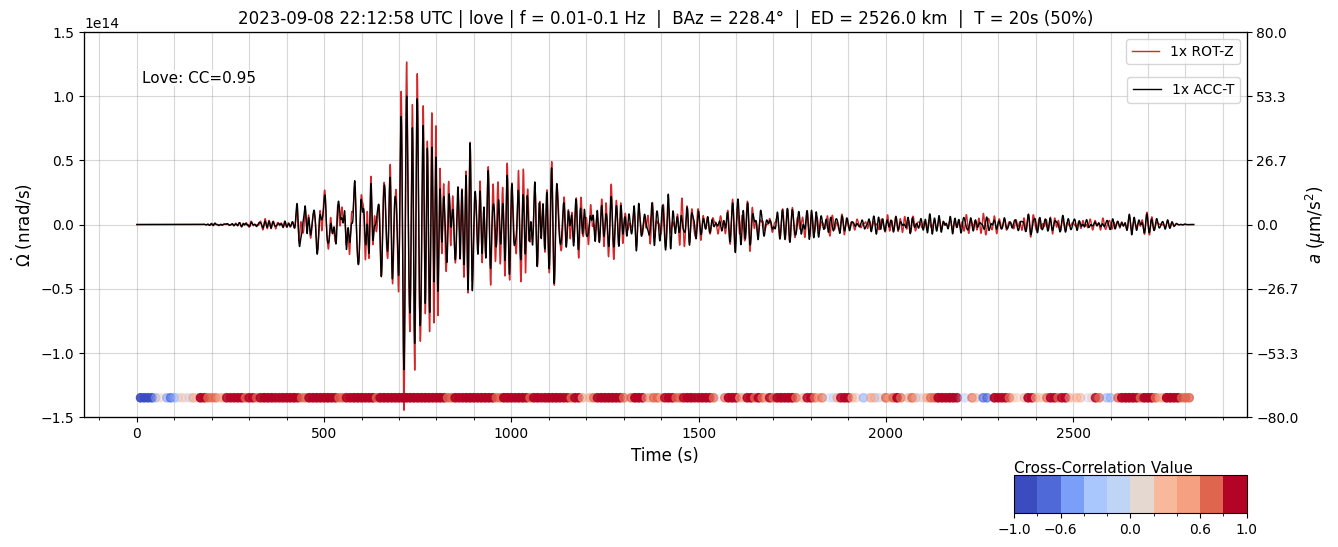

In [18]:
fig = plot_waveform_cc(
    rot0=sd.get_stream("rotation"),
    acc0=sd.get_stream("translation"),
    baz=ev['backazimuth'],
    distance=ev['distance_km'],
    fmin=sd.fmin,
    fmax=sd.fmax, 
    twin_sec=20,
    twin_overlap=0.5,
    wave_type="love"
)

In [ ]:
fig = plot_spectra_comparison_fill(
    rot=sd.get_stream("rotation"), 
    acc=sd.get_stream("translation"),
    fmin=sd.fmin,
    fmax=sd.fmax,
    ylog=False, xlog=False, fill=True
)

NameError: name 'plot_spectra_comparison_fill' is not defined

### Backazimuth Estimate

In [ ]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=1,
    baz_win_sec=50,
    baz_win_overlap=0.5,
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5  # optional
)

IndexError: list index out of range

In [ ]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=1,
    baz_win_sec=20,
    baz_win_overlap=0.5,
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5  # optional
)

IndexError: list index out of range

In [ ]:
fig, results = sd.compare_backazimuth_methods(
    Twin=20.0,
    Toverlap=0.5,
    cc_threshold=0.1,
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

### Analyse phase velocities

In [ ]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

In [ ]:
# Plot results
fig = sd.plot_velocities(
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = sd.plot_velocities(
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

In [ ]:
results =sd.compute_velocities_in_windows(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='odr',
    baz=ev['backazimuth']  # optional
)

### Compare RANSAC and ODR

In [ ]:
# Compute Love wave velocities
love_velocities_ransac = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_ransac = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.5,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Love wave velocities
love_velocities_odr = sd.compute_velocities(
    wave_type='love',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.7,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_odr = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=20.0,
    overlap=0.5,
    cc_threshold=0.7,
    method='odr',
    baz=ev['backazimuth']  # optional
)

In [ ]:
fig = plot_velocity_method_comparison(
    rayleigh_velocities_ransac,
    rayleigh_velocities_odr
)

In [ ]:
# love_velocities_win = sd.compute_velocities_in_windows(
#     wave_type="love",
#     win_time_s=20,
#     overlap=0.5,
#     cc_threshold=0.5,
#     adjusted_baz=True,
#     baz=0,
#     method='odr'
# )

# rayleigh_velocities_win = sd.compute_velocities_in_windows(
#     wave_type="rayleigh",
#     win_time_s=20,
#     overlap=0.5,
#     cc_threshold=0.5,
#     adjusted_baz=True,
#     baz=0,
#     method='odr'
# )

In [ ]:
# def plot_love_velocities_win(results_velocities, cc_threshold=0.0):

#     from numpy import array

#     # Convert arrays if needed
#     times = array(results_velocities['time'])
#     baz = array(results_velocities['backazimuth'])
#     vel = array(results_velocities['velocity'])
#     cc = array(results_velocities['ccoef'])

#     # apply threshold
#     mask = cc >= cc_threshold

#     # Create figure with space for colorbar
#     fig = plt.figure(figsize=(12, 8))
#     gs = fig.add_gridspec(2, 2, width_ratios=[15, 0.5], hspace=0.1)

#     # Create subplots
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
#     cax = fig.add_subplot(gs[:, 1])  # colorbar axis

#     # Plot backazimuth estimates
#     sc1 = ax1.scatter(results_velocities['time'][mask], results_velocities['backazimuth'][mask], 
#                     c=results_velocities['ccoef'][mask], cmap='viridis', 
#                     alpha=1, label='Estimated BAZ', zorder=2, vmin=0, vmax=1)
#     ax1.axhline(y=ev['backazimuth'], color='r', ls='--', label='Theoretical BAZ', zorder=0)

#     # Plot velocity estimates
#     sc2 = ax2.scatter(results_velocities['time'][mask], results_velocities['velocity'][mask], 
#                     c=results_velocities['ccoef'][mask], cmap='viridis', 
#                     alpha=1, label='Phase Velocity', zorder=2, vmin=0, vmax=1)

#     # Configure axes
#     ax1.set_ylabel('Backazimuth (°)')
#     ax1.grid(which='both', zorder=0, alpha=0.5)
#     ax1.legend()

#     ax2.set_ylim(0, 5000)
#     ax2.set_xlabel('Time (s)')
#     ax2.set_ylabel('Velocity (m/s)')
#     ax2.grid(which='both', zorder=0, alpha=0.5)
#     ax2.legend()

#     for a in [ax1, ax2]:
#         a.minorticks_on()

#     # Add colorbar
#     cb = plt.colorbar(sc1, cax=cax, label='Cross-Correlation Coefficient')

#     # title = f'{results_velocities["parameters"]["wave_type"].upper()} Wave Analysis'
#     # plt.suptitle(title, y=0.91)

#     plt.tight_layout()
#     return fig

# fig = plot_love_velocities_win(love_velocities_win,cc_threshold=0.7)

# fig = plot_love_velocities_win(rayleigh_velocities_win,cc_threshold=0.7)

### Test optimization of parameters with frequency and backazimuth in time windows

In [ ]:
# Get optimization results
params = sd.optimize_parameters(wave_type='love', 
                              fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 3}, 
                              baz_step=1,
                              twin_min=10,
                              overlap=0.75,
                              bandwidth_factor=2)

# Plot results using the imported function
fig = plot_optimization_results(params, wave_type='love',
                              vel_max_threshold=5000,
                              cc_threshold=0.85,
                              baz_theo=ev['backazimuth'])
plt.show()

In [ ]:
# Get optimization results
params = sd.optimize_parameters(wave_type='rayleigh', 
                              fbands={'fmin': 0.01, 'fmax': 0.2, 'octave_fraction': 6}, 
                              baz_step=1,
                              twin_min=10,
                              overlap=0.75,
                              bandwidth_factor=2)

# Plot results using the class method
fig = sd.plot_optimization_results(params, wave_type='rayleigh',
                                   vel_max_threshold=5000,
                                   cc_threshold=0.85,
                                   baz_theo=ev['backazimuth'])
plt.show()

In [ ]:
def plot_optimization_results(params, wave_type='love', vel_max_threshold=5000):
    """
    Plot optimization results including frequency bands, backazimuth, and velocities
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.colors import BoundaryNorm, ListedColormap
    
    font = 12

    # Create figure
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(3, 2, figure=fig, 
                 width_ratios=[1, 0.05], 
                 height_ratios=[1, 1, 1], 
                 hspace=0.25)
    
    # Convert data to arrays if needed
    times = np.array(params['times'])
    freqs = np.array(params['frequency']['center'])
    baz = np.array(params['backazimuth']['optimal'])
    vel = np.array(params['velocity'])
    cc = np.array(params['cross_correlation']['optimal'])
    
    # Create velocity mask
    vel_mask = vel <= vel_max_threshold
    
    # Set colorbar parameters
    vmin, vmax, vstep = 0.9, 1.0, 0.01
    levels = np.arange(vmin, vmax + vstep, vstep)  # steps of 0.01
    
    # Create discrete colormap
    n_bins = len(levels) - 1
    viridis = plt.cm.get_cmap('viridis')
    colors = viridis(np.linspace(0, 1, n_bins))
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, ncolors=len(levels)-1)
    
    # 1. Plot frequency band optimization
    ax1 = fig.add_subplot(gs[0, 0])
    # Plot grey dots for values above threshold
    ax1.scatter(times[~vel_mask], freqs[~vel_mask], 
                color='grey', alpha=0.3, label=f'v > {vel_max_threshold} m/s')
    # Plot colored dots for values below threshold
    sc1 = ax1.scatter(times[vel_mask], freqs[vel_mask], 
                     c=cc[vel_mask], cmap=cmap, alpha=0.7,
                     norm=norm, edgecolor='black')
    ax1.set_ylabel('Frequency (Hz)', fontsize=font)
    ax1.set_yscale('log')
    ax1.set_title('Frequency Band Optimization', fontsize=font)
    ax1.grid(which='both', zorder=0, alpha=0.5)
    ax1.legend()
    ax1.set_ylim(freqs.min(), freqs.max())
    
    # 2. Plot backazimuth results
    ax2 = fig.add_subplot(gs[1, 0])
    # Plot grey dots for values above threshold
    ax2.scatter(times[~vel_mask], baz[~vel_mask], 
                color='grey', alpha=0.3, label=f'v > {vel_max_threshold} m/s')
    # Plot colored dots for values below threshold
    sc2 = ax2.scatter(times[vel_mask], baz[vel_mask],
                     c=cc[vel_mask], cmap=cmap, alpha=0.7,
                     norm=norm, edgecolor='black')
    ax2.set_ylabel('Backazimuth (°)', fontsize=font)
    ax2.grid(which='both', zorder=0, alpha=0.5)
    ax2.legend()
    ax2.set_title('Optimal Backazimuth', fontsize=font)
    ax2.set_ylim(0, 360)

    ax2.set_yticks([0, 90, 180, 270, 360])
    ax2.set_yticklabels(['0', '90', '180', '270', '360'])

    # 3. Plot velocity results
    ax3 = fig.add_subplot(gs[2, 0])
    # Plot grey dots for values above threshold
    ax3.scatter(times[~vel_mask], vel[~vel_mask], 
                color='grey', alpha=0.3)
    # Plot colored dots for values below threshold
    sc3 = ax3.scatter(times[vel_mask], vel[vel_mask],
                     c=cc[vel_mask], cmap=cmap, alpha=0.7,
                     norm=norm, edgecolor='black')
    ax3.set_xlabel('Time (s)', fontsize=font)
    ax3.set_ylabel('Velocity (m/s)', fontsize=font)
    ax3.grid(which='both', zorder=0, alpha=0.5)
    ax3.set_title('Phase Velocity', fontsize=font)
    ax3.set_ylim(0, vel_max_threshold)
    
    for ax in [ax1, ax2, ax3]:
        ax.minorticks_on()
        ax.set_xlim(times.min()-0.01*times.max(), times.max()+0.01*times.max())
    
    # Add vertical colorbar
    cax = fig.add_subplot(gs[:, 1])
    cbar = plt.colorbar(sc3, cax=cax,
                       ticks=levels)
    cbar.set_label('Cross-correlation Coefficient', fontsize=font)
    
    plt.suptitle(f'{wave_type.capitalize()} Wave Analysis Results', y=0.95)
    plt.tight_layout()
    
    # Print statistics for values below threshold
    print("\nOptimal Parameters (v ≤ {vel_threshold} m/s):")
    print(f"Mean Velocity: {np.nanmean(vel[vel_mask]):.1f} m/s")
    print(f"Mean Backazimuth: {np.nanmean(baz[vel_mask]):.1f}°")
    print(f"Mean Cross-correlation: {np.nanmean(cc[vel_mask]):.3f}")
    print(f"Number of points: {np.sum(vel_mask)} / {len(vel_mask)}")
    
    return fig

# Usage:
fig = plot_optimization_results(params, wave_type='love', vel_max_threshold=5000)
plt.show()